<a href="https://colab.research.google.com/github/Safa06/Thesis/blob/main/channel_att_IP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# VGG16
#import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import scipy.io
from scipy.io import loadmat
#from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint

In [ ]:
mat_data1= scipy.io.loadmat('Indian_pines_corrected.mat')
mat_data2=scipy.io.loadmat('Indian_pines_gt.mat')
X=mat_data1['indian_pines_corrected']
y=mat_data2['indian_pines_gt']
print(X.shape)
print(y.shape)


(145, 145, 200)
(145, 145)


In [ ]:
# Apply PCA to minimize band from 200 to 3 band
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

K = 16
X,pca= applyPCA(X,numComponents=K)
print(X.shape, y.shape)



#padding with zero
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

(145, 145, 16) (145, 145)


In [ ]:
# Window for patches
windowSize=11
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

X, y = createImageCubes(X, y, windowSize=windowSize)
#print(X.shape,y.shape)

In [ ]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3074, 11, 11, 16) (7175, 11, 11, 16) (3074,) (7175,)


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# def channel_attention_module(inputs, reduction_ratio=16):
#   """Implements a channel attention module.

#   Args:
#       inputs: The input tensor of shape (batch_size, height, width, channels).
#       reduction_ratio: The reduction ratio for channel squeezing. Defaults to 16.

#   Returns:
#       A tensor with the same shape as the input, containing the channel-wise attention weights.
#   """

#   avg_pool = layers.GlobalAveragePooling2D()(inputs)  # Average pool across spatial dimensions
#   max_pool = layers.GlobalMaxPooling2D()(inputs)  # Max pool across spatial dimensions

#   shared_conv = layers.Conv1D(inputs.shape[-1] // reduction_ratio, kernel_size=1, activation='relu')(
#       keras.layers.concatenate([avg_pool, max_pool]))  # Concatenate and reduce dimensionality

#   shared_conv = layers.Conv1D(inputs.shape[-1], kernel_size=1, activation='sigmoid')(shared_conv)  # Project back to channel dimension and apply sigmoid

#   return inputs * shared_conv  # Multiply input by channel-wise attention weights


In [ ]:
# input_shape = (11,11,16)
# S = windowSize
# inputs = keras.Input(shape=input_shape)
# L = K
# #output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

# ## input layer
# #input_shape=(11,11,16)

# #for 3D CNN--input_layer=Input(S, S, L, 1)

# #Model
# # model = Sequential()

# # #Block 1

# # x=model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same")(inputs))
# # x=model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding="same"))(x)
# # x=model.add(MaxPooling2D((2, 2), strides=(2, 2)))(x)
# # x=channel_attention_module(x);

# # # Block 2
# # x=model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(MaxPooling2D((2, 2), strides=(2, 2)))(x)
# # x=channel_attention_module(x);

# # # Block 3
# # x=model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(MaxPooling2D((2, 2), strides=(2, 2)))(x)
# # x=channel_attention_module(x);

# # # Block 4
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # # model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # x=model.add(MaxPooling2D((1, 1), strides=(1, 1)))(x)
# # x=channel_attention_module(x);


# # # Block 5
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # x=model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
# # #model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # x=model.add(MaxPooling2D((1, 1), strides=(1, 1)))(x)
# # x=channel_attention_module(x);

# # # Fully connected layers
# # x=model.add(Flatten())(x)
# # x=model.add(Dense(units=4096, activation='relu'))
# # x=model.add(Dense(units=4096, activation='relu'))
# # x=model.add(Dense(units=16, activation='softmax'))

# # model.build()
# # model.summary()


# # model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# inputs = keras.Input(shape=input_shape)

# def channel_attention_module(inputs, reduction_ratio=16):
#   """Implements a channel attention module.

#   Args:
#       inputs: The input tensor of shape (batch_size, height, width, channels).
#       reduction_ratio: The reduction ratio for channel squeezing. Defaults to 16.

#   Returns:
#       A tensor with the same shape as the input, containing the channel-wise attention weights.
#   """

#   avg_pool = layers.Reshape((1, inputs.shape[-1]))(layers.GlobalAveragePooling2D()(inputs)) # Average pool across spatial dimensions
#   max_pool = layers.Reshape((1, inputs.shape[-1]))(layers.GlobalMaxPooling2D()(inputs))  # Max pool across spatial dimensions

#   shared_conv = layers.Conv1D(inputs.shape[-1] // reduction_ratio, kernel_size=1, activation='relu')(
#       keras.layers.concatenate([avg_pool, max_pool]))  # Concatenate and reduce dimensionality

#   shared_conv = layers.Conv1D(inputs.shape[-1], kernel_size=1, activation='sigmoid')(shared_conv)  # Project back to channel dimension and apply sigmoid

#   return inputs * shared_conv  # Multiply input by channel-wise attention weights


# # def channel_attention_module(inputs, reduction_ratio=16):
# #   """Implements a channel attention module.

# #   Args:
# #       inputs: The input tensor of shape (batch_size, height, width, channels).
# #       reduction_ratio: The reduction ratio for channel squeezing. Defaults to 16.

# #   Returns:
# #       A tensor with the same shape as the input, containing the channel-wise attention weights.
# #   """

# #   avg_pool = layers.GlobalAveragePooling2D()(inputs)  # Average pool across spatial dimensions
# #   max_pool = layers.GlobalMaxPooling2D()(inputs)  # Max pool across spatial dimensions

# #   shared_conv = layers.Conv1D(inputs.shape[-1]
# #                   // reduction_ratio, kernel_size=1, activation='relu')(
# #       keras.layers.concatenate([avg_pool, max_pool]))  # Concatenate and reduce dimensionality

# #   shared_conv = layers.Conv1D(inputs.shape[-1], kernel_size=1, activation='sigmoid')(shared_conv)  # Project back to channel dimension and apply sigmoid

# #   return inputs * shared_conv  # Multiply input by channel-wise attention weights

# # def vgg16_with_channel_attention(input_shape, num_classes):
# #   """Creates a scratch VGG16 model with channel attention in convolutional blocks.

# #   Args:
# #       input_shape: The input shape of the model (height, width, channels).
# #       num_classes: The number of classes in the HSI classification task.

# #   Returns:
# #       A compiled Keras model ready for training.
# #   """



#   # Block 1
# x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
# x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
# x = channel_attention_module(x)  # Add channel attention after block 1

# # Block 2
# x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
# x = channel_attention_module(x)  # Add channel attention after block 2

# # Block 3
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
# #x = channel_attention_module(x)  # Add channel attention after block 3

# # Block 4
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((1, 1), strides=(1, 1))(x)
# #x = channel_attention_module(x)  # Add channel attention after block 4

# # Block 5
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((1, 1), strides=(1, 1))(x)
# #x = channel_attention_module(x)

#  # Fully connected layers
# # x=model.add(Flatten())(x)
# # x=model.add(Dense(units=4096, activation='relu'))
# # x=model.add(Dense(units=4096, activation='relu'))
# # x=model.add(Dense(units=16, activation='softmax'))


# # Fully-connected layers for classification
# x = layers.Flatten()(x)
# x = layers.Dense(4096, activation='relu')(x)  # Example: First dense layer with 4096 units and ReLU activation
# #x = layers.Dropout(0.5)(x)  # Example: Dropout for regularization
# x = layers.Dense(4096, activation='relu')(x)  # Example: Second dense layer with 4096 units and ReLU activation
# #x = layers.Dropout(0.5)(x)  # Example: Dropout for regularization
# outputs = layers.Dense(16, activation='softmax')(x)  # Final output layer with softmax activation


# model = create_vgg16_ca(input_shape, num_classes)
# model.summary()

# model.build(input_shape=input_shape)



# # Compile the model
# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])






In [ ]:
!pip install tensorflow==2.11.0

In [ ]:
!pip install keras

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# def channel_attention_module(inputs, reduction_ratio=16):
#   """Implements a channel attention module.

#   Args:
#       inputs: The input tensor of shape (batch_size, height, width, channels).
#       reduction_ratio: The reduction ratio for channel squeezing. Defaults to 16.

#   Returns:
#       A tensor with the same shape as the input, containing the channel-wise attention weights.
#   """

#   avg_pool = layers.GlobalAveragePooling2D()(inputs)  # Average pool across spatial dimensions
#   max_pool = layers.GlobalMaxPooling2D()(inputs)  # Max pool across spatial dimensions

# # Reshape the pooling outputs to have three dimensions
#   # avg_pool = layers.Reshape((1, 1, avg_pool.shape[-1]))
#   # max_pool = layers.Reshape((1, 1, max_pool.shape[-1]))

#   # Reshape the pooling outputs to have three dimensions
#   avg_pool = layers.Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
#   max_pool = layers.Reshape((1, 1, max_pool.shape[-1]))(max_pool)

#   # Print the shapes of reshaped tensors for debugging
#   print("Avg Pool Shape:", avg_pool.shape)
#   print("Max Pool Shape:", max_pool.shape)




#   shared_conv = layers.Conv1D(inputs.shape[-1] // reduction_ratio, kernel_size=1, activation='relu')(
#       keras.layers.concatenate([avg_pool, max_pool]))  # Concatenate and reduce dimensionality

#   shared_conv = layers.Conv1D(inputs.shape[-1], kernel_size=1, activation='sigmoid')(shared_conv)  # Project back to channel dimension and apply sigmoid

#   return inputs * shared_conv  # Multiply input by channel-wise attention weights


import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Multiply
import tensorflow.keras.layers as layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.scale = self.add_weight("scale", shape=[channels,], initializer=tf.keras.initializers.Ones(), trainable=True)

    def call(self, inputs):
        x = self.avg_pool(inputs)
        x = tf.expand_dims(tf.expand_dims(x, axis=1), axis=1)  # Add dimensions for broadcasting
        x = tf.math.multiply(x, self.scale)
        return Multiply()([inputs, x])




def vgg16_with_channel_attention(input_shape, num_classes):
  """Creates a scratch VGG16 model with channel attention in convolutional blocks.

  Args:
      input_shape: The input shape of the model (height, width, channels).
      num_classes: The number of classes in the HSI classification task.

  Returns:
      A compiled Keras model ready for training.
  """

  inputs = keras.Input(shape=input_shape)

  # Block 1
  x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
  x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
  #x = channel_attention_module(x)
  x=ChannelAttention()(x)  # Add channel attention after block 1

  # Block 2
  x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
  #x = channel_attention_module(x)
  #x=ChannelAttention()(x)  # Add channel attention after block 2

  # Block 3
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
  #x = channel_attention_module(x)
  #x=ChannelAttention()(x)  # Add channel attention after block 3

  # Block 4
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((1, 1), strides=(1, 1))(x)
  #x = channel_attention_module(x)
  #x=ChannelAttention()(x)  # Add channel attention after block 4

  # Block 5
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((1, 1), strides=(1, 1))(x)
  #x = channel_attention_module(x)
  #x=ChannelAttention()(x)  # Add channel attention after block


  # Flatten the output from the final convolutional layer
  x = layers.Flatten()(x)

  # Fully-connected layers for classification
  x = layers.Dense(4096, activation='relu')(x)  # Example: First dense layer with 4096 units and ReLU activation
  #x = layers.Dropout(0.5)(x)  # Example: Dropout for regularization
  x = layers.Dense(4096, activation='relu')(x)  # Example: Second dense layer with 4096 units and ReLU activation
  #x = layers.Dropout(0.5)(x)  # Example: Dropout for regularization
  outputs = layers.Dense(num_classes, activation='softmax')(x)  # Final output layer with softmax activation

  # Compile the model
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model


input_shape = (11, 11, 16)
num_classes = 16
#input_shape = X_train.shape[1:]  # Get input shape from training data
model = vgg16_with_channel_attention(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 11, 16)]      0         
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 64)        9280      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 64)         0         
 )                                                               
                                                                 
 channel_attention (ChannelA  (None, 5, 5, 64)         64        
 ttention)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856 

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
# checkpoint for saving epochs
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100,batch_size=32,callbacks=callbacks_list)

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 2.4355 - accuracy: 0.2375
Epoch 1: accuracy improved from -inf to 0.23748, saving model to best-model.hdf5
97/97 [==============================] - 234s 2s/step - loss: 2.4355 - accuracy: 0.2375 - val_loss: 2.1424 - val_accuracy: 0.2386
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 1.9679 - accuracy: 0.2804
Epoch 2: accuracy improved from 0.23748 to 0.28042, saving model to best-model.hdf5
97/97 [==============================] - 204s 2s/step - loss: 1.9679 - accuracy: 0.2804 - val_loss: 1.7127 - val_accuracy: 0.3629
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 1.4878 - accuracy: 0.4310
Epoch 3: accuracy improved from 0.28042 to 0.43103, saving model to best-model.hdf5
97/97 [==============================] - 210s 2s/step - loss: 1.4878 - accuracy: 0.4310 - val_loss: 1.3427 - val_accuracy: 0.4626
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 1.2195 

In [13]:
# from keras.models import Model
# # Load the model
# model.load_weights('best-model.hdf5')

# # Calculate remaining epochs
# initial_epoch = last_completed_epoch + 1
# remaining_epochs = total_epochs - initial_epoch

# # Resume training
# model.fit(X_train, y_train,validation_data=(X_test,y_test), initial_epoch=initial_epoch, epochs=total_epochs, callbacks=[checkpoint_callback])

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best-model.hdf5t.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

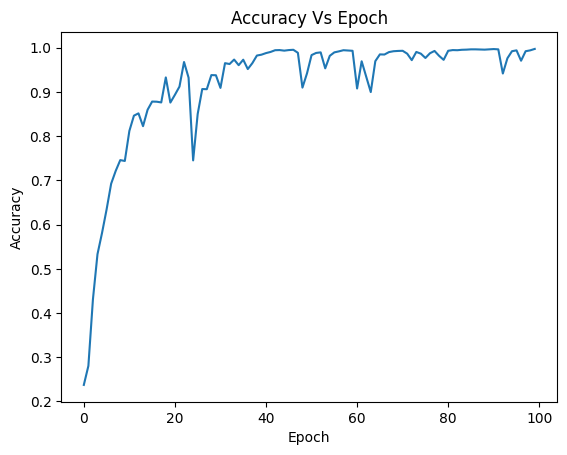

<Figure size 640x480 with 0 Axes>

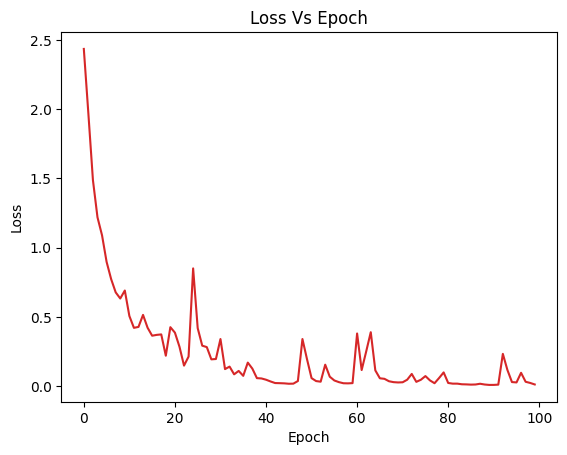

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure()
plt.plot(history.history['accuracy'],color ='tab:blue')
plt.title('Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy_Vs_Epoch.png',dpi=300)

plt.figure()
plt.plot(history.history['loss'],color ='tab:red')
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss_Vs_Epoch.png',dpi=300)